## Welcome!

This notebook explores historical NCAA Division I men's and women's basketball data to predict the outcomes of March Madness tournament games. We'll leverage provided datasets containing team information, game results, and tournament seeds to build a predictive model. Data files are prefixed with 'M' for men's, 'W' for women's,and some span both.

## Goal: 
Minimize the Brier score, the evaluation metric for this competition.

## Approach:
 1. Start with a basic model using seed differences.
 2. Gradually incorporate more sophisticated features and techniques.


# <p style="padding:10px;background-color:#00ffc3;margin:0;color:#102d02;font-family:newtimeroman;font-size:100%;text-align:center;border-radius:15px 50px;overflow:hidden;font-weight:500;border: 3px solid #00a5a0;">Brier Score</p>


The **Brier score** is a strictly proper scoring rule that measures the accuracy of probabilistic predictions. For unidimensional predictions, it is strictly equivalent to the mean squared error as applied to predicted probabilities.

The Brier score is applicable to tasks in which predictions must assign probabilities to a set of mutually exclusive discrete outcomes or classes. The set of possible outcomes can be either binary or categorical in nature, and the probabilities assigned to this set of outcomes must sum to one (where each individual probability is in the range of 0 to 1). It was proposed by Glenn W. Brier in 1950.[1]

The Brier score can be thought of as a cost function. More precisely, across all items 
i
∈
1...
N
in a set of N predictions, the Brier score measures the mean squared difference between:

- The predicted probability assigned to the possible outcomes for item i
- The actual outcome 
o
i

Therefore, the lower the Brier score is for a set of predictions, the better the predictions are calibrated. Note that the Brier score, in its most common formulation, takes on a value between zero and one, since this is the square of the largest possible difference between a predicted probability (which must be between zero and one) and the actual outcome (which can take on values of only 0 or 1). In the original (1950) formulation of the Brier score, the range is double, from zero to two.

The Brier score is appropriate for binary and categorical outcomes that can be structured as true or false, but it is inappropriate for ordinal variables which can take on three or more values.

Links: https://en.wikipedia.org/wiki/Brier_score

# <p style="padding:10px;background-color:#00ffc3;margin:0;color:#102d02;font-family:newtimeroman;font-size:100%;text-align:center;border-radius:15px 50px;overflow:hidden;font-weight:500;border: 3px solid #00a5a0;">Import Libraries</p>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import brier_score_loss
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from xgboost import XGBClassifier  # Or LightGBM, CatBoost
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

# <p style="padding:10px;background-color:#00ffc3;margin:0;color:#102d02;font-family:newtimeroman;font-size:100%;text-align:center;border-radius:15px 50px;overflow:hidden;font-weight:500;border: 3px solid #00a5a0;">Load the Data</p>

In [4]:
# Load the datasets 
#data_dir = "/kaggle/input/march-machine-learning-mania-2025/"
data_dir = "march-machine-learning-mania-2025/"

In [79]:
#Men's data
m_teams = pd.read_csv(data_dir + "MTeams.csv")
m_tourney_compact_results = pd.read_csv(data_dir + "MNCAATourneyCompactResults.csv")
m_regular_season_compact_results = pd.read_csv(data_dir + "MRegularSeasonCompactResults.csv")
# m_tourney_detailed_results = pd.read_csv(data_dir + "MNCAATourneyDetailedResults.csv")
# m_regular_season_detailed_results = pd.read_csv(data_dir + "MRegularSeasonDetailedResults.csv")
m_seeds = pd.read_csv(data_dir + "MNCAATourneySeeds.csv")

#Women's data
w_teams = pd.read_csv(data_dir + "WTeams.csv")
w_tourney_compact_results = pd.read_csv(data_dir + "WNCAATourneyCompactResults.csv")
w_regular_season_compact_results = pd.read_csv(data_dir + "WRegularSeasonCompactResults.csv")
# w_tourney_detailed_results = pd.read_csv(data_dir + "WNCAATourneyDetailedResults.csv")
# w_regular_season_detailed_results = pd.read_csv(data_dir + "WRegularSeasonDetailedResults.csv")
w_seeds = pd.read_csv(data_dir + "WNCAATourneySeeds.csv")



# <p style="padding:10px;background-color:#00ffc3;margin:0;color:#102d02;font-family:newtimeroman;font-size:100%;text-align:center;border-radius:15px 50px;overflow:hidden;font-weight:500;border: 3px solid #00a5a0;">Data Preprocessing and Feature Engineering</p>

In [80]:
# 1. Seed Processing (Men's and Women's)
def prepare_seed(seeds):
    seeds['seed_int'] = seeds.Seed.apply(lambda x: int(x[1:3]))
    seeds = seeds[['Season', 'TeamID', 'seed_int']]
    return seeds

m_seeds = prepare_seed(m_seeds)
w_seeds = prepare_seed(w_seeds)

# 2. Game Results Processing (Men's and Women's)
def prepare_data(regular_season_results, tourney_results):
    regular_season_results['tourney'] = 0
    tourney_results['tourney'] = 1
    games = pd.concat((regular_season_results, tourney_results), axis=0, ignore_index=True)
    games['WTeamWon'] = 1
    games_reversed = games[games.WTeamID < games.LTeamID].copy()
    games_reversed[['WTeamID', 'LTeamID']] = games_reversed[['LTeamID', 'WTeamID']]
    games_reversed['WTeamWon'] = 0
    games = pd.concat((games, games_reversed), ignore_index=True)
    games['ID'] = games.apply(lambda r: '_'.join(map(str, [r['Season'], r['WTeamID'], r['LTeamID']])), axis=1)
    return games

m_games = prepare_data(m_regular_season_compact_results, m_tourney_compact_results)
w_games = prepare_data(w_regular_season_compact_results, w_tourney_compact_results)


In [81]:
m_games

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,tourney,WTeamWon,ID
0,1985,20,1228,81,1328,64,N,0,0,1,1985_1228_1328
1,1985,25,1106,77,1354,70,H,0,0,1,1985_1106_1354
2,1985,25,1112,63,1223,56,H,0,0,1,1985_1112_1223
3,1985,25,1165,70,1432,54,H,0,0,1,1985_1165_1432
4,1985,25,1192,86,1447,74,H,0,0,1,1985_1192_1447
...,...,...,...,...,...,...,...,...,...,...,...
289396,2024,144,1222,54,1181,51,N,0,1,0,2024_1222_1181
289397,2024,145,1155,89,1104,82,N,0,1,0,2024_1155_1104
289398,2024,145,1228,77,1163,52,N,0,1,0,2024_1228_1163
289399,2024,146,1397,72,1345,66,N,0,1,0,2024_1397_1345


In [56]:
# 3. Merge Seeds with Game Results (Men's and Women's)
def merge_seed_features(games, seeds):
    games = pd.merge(games, seeds, left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left')
    games.rename(columns={'seed_int': 'WSeed'}, inplace=True)
    games = games.drop('TeamID', axis=1)
    games = pd.merge(games, seeds, left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], how='left')
    games.rename(columns={'seed_int': 'LSeed'}, inplace=True)
    games = games.drop('TeamID', axis=1)
    return games

m_games = merge_seed_features(m_games, m_seeds)
w_games = merge_seed_features(w_games, w_seeds)

# 4. Seed Difference Feature (Men's and Women's)
m_games['SeedDiff'] = m_games.WSeed - m_games.LSeed
w_games['SeedDiff'] = w_games.WSeed - w_games.LSeed

In [76]:
m_games.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,tourney,WTeamWon,ID,WSeed,LSeed,SeedDiff
0,1985,20,1228,81,1328,64,N,0,0,1,1985_1228_1328,3.0,1.0,2.0
7,1985,25,1242,58,1268,56,N,0,0,1,1985_1242_1268,3.0,5.0,-2.0
9,1985,25,1305,97,1424,89,H,0,0,1,1985_1305_1424,14.0,4.0,10.0
45,1985,26,1412,59,1228,52,N,0,0,1,1985_1412_1228,7.0,3.0,4.0
50,1985,26,1439,102,1330,76,H,0,0,1,1985_1439_1330,9.0,12.0,-3.0


# <p style="padding:10px;background-color:#00ffc3;margin:0;color:#102d02;font-family:newtimeroman;font-size:100%;text-align:center;border-radius:15px 50px;overflow:hidden;font-weight:500;border: 3px solid #00a5a0;">Model Training and Evaluation</p>

In [73]:
features = ['SeedDiff']
target = 'WTeamWon'

# Drop rows with NaN values
m_games = m_games.dropna(subset=features + [target])
w_games = w_games.dropna(subset=features + [target])

X_m = m_games[features]
y_m = m_games[target]
X_w = w_games[features]
y_w = w_games[target]


In [68]:
# Split into training and testing sets (Men's and Women's)

X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_m, y_m, test_size=0.2, random_state=42)  # Consistent random_state
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X_w, y_w, test_size=0.2, random_state=42)  # Consistent random_state

In [69]:
# Standardize the data
scaler_m = StandardScaler()
X_train_m = scaler_m.fit_transform(X_train_m)
X_test_m = scaler_m.transform(X_test_m)

scaler_w = StandardScaler()
X_train_w = scaler_w.fit_transform(X_train_w)
X_test_w = scaler_w.transform(X_test_w)

In [70]:
# Train Gradient Boosting Machine Model (Men's and Women's)
model_m = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')  # Added random_state for reproducibility, address deprecation warning
model_m.fit(X_train_m, y_train_m)

model_w = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')  # Added random_state for reproducibility, address deprecation warning
model_w.fit(X_train_w, y_train_w)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

Men's Brier Score: 0.17830130113631534
Women's Brier Score: 0.15730457285340732


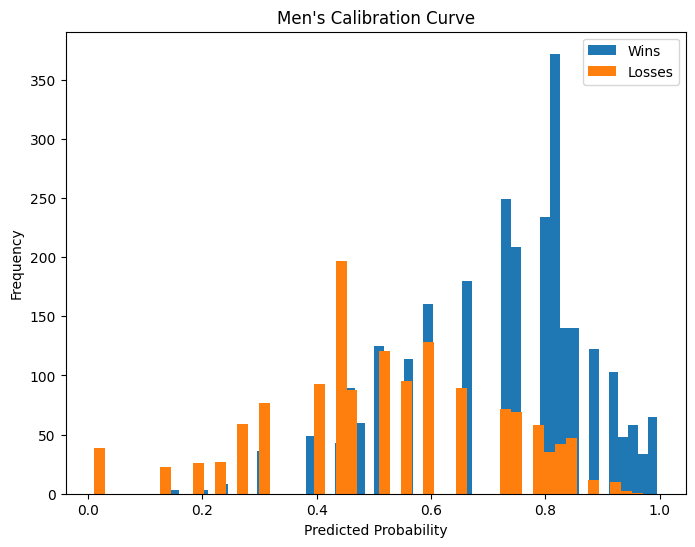

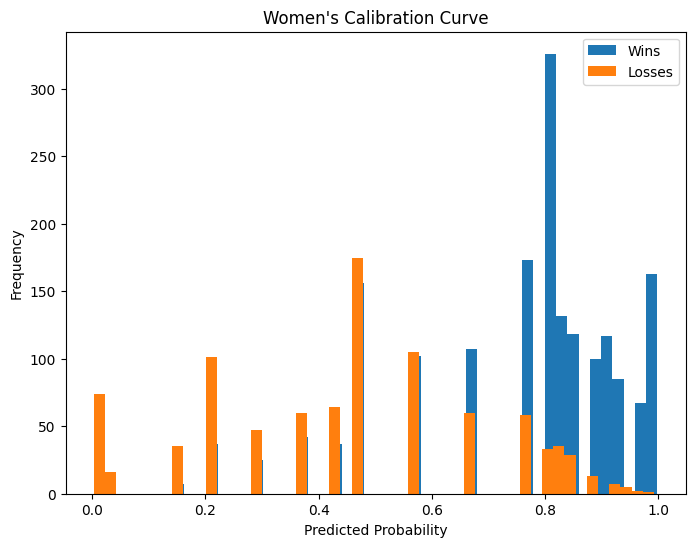

In [71]:
preds_m = model_m.predict_proba(X_test_m)[:, 1]
brier_score_m = brier_score_loss(y_test_m, preds_m)
print(f'Men\'s Brier Score: {brier_score_m}')
preds_w = model_w.predict_proba(X_test_w)[:, 1]
brier_score_w = brier_score_loss(y_test_w, preds_w)
print(f'Women\'s Brier Score: {brier_score_w}')

# --- Visualization ---

def plot_calibration_curve(y_true, y_prob, title='Calibration Curve'):
    plt.figure(figsize=(8, 6))
    plt.hist(y_prob[y_true == 1], bins=50, label='Wins')
    plt.hist(y_prob[y_true == 0], bins=50, label='Losses')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.legend()
    plt.show()

plot_calibration_curve(y_test_m, preds_m, title='Men\'s Calibration Curve')
plot_calibration_curve(y_test_w, preds_w, title='Women\'s Calibration Curve')


# <p style="padding:10px;background-color:#00ffc3;margin:0;color:#102d02;font-family:newtimeroman;font-size:100%;text-align:center;border-radius:15px 50px;overflow:hidden;font-weight:500;border: 3px solid #00a5a0;">Submission</p>

In [38]:
def predict_submission(submission, seeds, model, scaler):
    """
    Prepares submission data and makes predictions
    
    Parameters:
    submission (pd.DataFrame): Submission dataframe with ID column
    seeds (pd.DataFrame): Seeds information
    model: Trained model object
    scaler: Fitted scaler object
    
    Returns:
    pd.DataFrame: Submission dataframe with predictions
    """
    # Extract season and team IDs
    submission['Season'] = submission['ID'].apply(lambda x: int(x.split('_')[0]))
    submission['Team1'] = submission['ID'].apply(lambda x: int(x.split('_')[1]))
    submission['Team2'] = submission['ID'].apply(lambda x: int(x.split('_')[2]))

    # Merge seed information for both teams
    for team_num in [1, 2]:
        submission = pd.merge(
            submission, 
            seeds,
            left_on=['Season', f'Team{team_num}'],
            right_on=['Season', 'TeamID'],
            how='left'
        )
        submission.rename(columns={'seed_int': f'Team{team_num}Seed'}, inplace=True)
        submission = submission.drop('TeamID', axis=1)

    

    # Create tournament indicator if it's in features list
    if 'tourney' in features:
        submission['tourney'] = 1  # Since this is tournament data

    # Handle missing values
    for col in features:
        if col in submission.columns and submission[col].isnull().any():
            print(f"WARNING: Submission contains NaN values in {col}. Filling with 0. This may hurt prediction accuracy.")
            submission[col] = submission[col].fillna(0)

    # Verify all required features are present
    missing_features = [f for f in features if f not in submission.columns]
    if missing_features:
        raise ValueError(f"Missing required features: {missing_features}")

    # Prepare features for prediction
    X_submit = submission[features]

    # Scale the submission data
    X_submit_scaled = scaler.transform(X_submit)

    # Make predictions
    preds = model.predict_proba(X_submit_scaled)[:, 1]
    submission['Pred'] = preds
    
    return submission


In [37]:
# def predict_submission(submission, seeds, model, scaler):  # Pass scaler to the function
#     submission['Season'] = submission['ID'].apply(lambda x: int(x.split('_')[0]))
#     submission['Team1'] = submission['ID'].apply(lambda x: int(x.split('_')[1]))
#     submission['Team2'] = submission['ID'].apply(lambda x: int(x.split('_')[2]))

#     submission = pd.merge(submission, seeds, left_on=['Season', 'Team1'], right_on=['Season', 'TeamID'], how='left')
#     submission.rename(columns={'seed_int': 'Team1Seed'}, inplace=True)
#     submission = submission.drop('TeamID', axis=1)

#     submission = pd.merge(submission, seeds, left_on=['Season', 'Team2'], right_on=['Season', 'TeamID'], how='left')
#     submission.rename(columns={'seed_int': 'Team2Seed'}, inplace=True)
#     submission = submission.drop('TeamID', axis=1)

#     submission['SeedDiff'] = submission.Team1Seed - submission.Team2Seed

#     #CHECK FOR NANS BEFORE PREDICTION
#     if submission[['SeedDiff']].isnull().any().any():
#         print("WARNING: Submission contains NaN values in SeedDiff.  Filling with 0. This may hurt prediction accuracy.")
#         submission['SeedDiff'] = submission['SeedDiff'].fillna(0) # or use .mean() if appropriate

#     X_submit = submission[['SeedDiff']]

#     # Scale the submission data
#     X_submit_scaled = scaler.transform(X_submit)

#     preds = model.predict_proba(X_submit_scaled)[:, 1]
#     submission['Pred'] = preds
#     return submission

# Load the Sample Submission
#data_dir = "/kaggle/input/march-machine-learning-mania-2025/" # or the correct path
submission = pd.read_csv(data_dir + "SampleSubmissionStage2.csv")


# Identify Men's and Women's games based on Team IDs.  Critical to avoid duplicate IDs.
m_teams = pd.read_csv(data_dir + "MTeams.csv")  # Load necessary data here
w_teams = pd.read_csv(data_dir + "WTeams.csv")
men_teams_ids = m_teams['TeamID'].unique()
women_teams_ids = w_teams['TeamID'].unique()


def is_men_game(id_str):
    team1_id = int(id_str.split('_')[1])
    team2_id = int(id_str.split('_')[2])
    return (team1_id in men_teams_ids) and (team2_id in men_teams_ids)

def is_women_game(id_str):
    team1_id = int(id_str.split('_')[1])
    team2_id = int(id_str.split('_')[2])
    return (team1_id in women_teams_ids) and (team2_id in women_teams_ids)


m_submission = submission[submission['ID'].apply(is_men_game)].copy()
w_submission = submission[submission['ID'].apply(is_women_game)].copy()


# Load seeds AFTER filtering submission dataframes
m_seeds = pd.read_csv(data_dir + "MNCAATourneySeeds.csv")  # Load necessary data here
w_seeds = pd.read_csv(data_dir + "WNCAATourneySeeds.csv")

# def prepare_seed(seeds):
#     seeds['seed_int'] = seeds.Seed.apply(lambda x: int(x[1:3]))
#     seeds = seeds[['Season', 'TeamID', 'seed_int']]
#     return seeds

# m_seeds = prepare_seed(m_seeds)
# w_seeds = prepare_seed(w_seeds)


In [38]:
m_seeds

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374
...,...,...,...
2553,2024,Z12,1241
2554,2024,Z13,1436
2555,2024,Z14,1324
2556,2024,Z15,1443


# Submission Funcution Debugging

In [35]:
def predict_submission(submission, seeds, model, scaler):  # Pass scaler to the function
    submission['Season'] = submission['ID'].apply(lambda x: int(x.split('_')[0]))
    submission['Team1'] = submission['ID'].apply(lambda x: int(x.split('_')[1]))
    submission['Team2'] = submission['ID'].apply(lambda x: int(x.split('_')[2]))

    submission = pd.merge(submission, seeds, left_on=['Season', 'Team1'], right_on=['Season', 'TeamID'], how='left')
    submission.rename(columns={'seed_int': 'Team1Seed'}, inplace=True)
    submission = submission.drop('TeamID', axis=1)

    # submission = pd.merge(submission, seeds, left_on=['Season', 'Team2'], right_on=['Season', 'TeamID'], how='left')
    # submission.rename(columns={'seed_int': 'Team2Seed'}, inplace=True)
    # submission = submission.drop('TeamID', axis=1)

    # submission['SeedDiff'] = submission.Team1Seed - submission.Team2Seed

    # #CHECK FOR NANS BEFORE PREDICTION
    # if submission[['SeedDiff']].isnull().any().any():
    #     print("WARNING: Submission contains NaN values in SeedDiff.  Filling with 0. This may hurt prediction accuracy.")
    #     submission['SeedDiff'] = submission['SeedDiff'].fillna(0) # or use .mean() if appropriate

    # X_submit = submission[['SeedDiff']]

    # # Scale the submission data
    # X_submit_scaled = scaler.transform(X_submit)

    # preds = model.predict_proba(X_submit_scaled)[:, 1]
    # submission['Pred'] = preds
    return submission

predict_submission(m_submission, m_seeds, model_m, scaler_m)

,ID,Pred,Season,Team1,Team2,Team1Seed
0,2025_1101_1102,0.5,2025,1101,1102,NaN
1,2025_1101_1103,0.5,2025,1101,1103,NaN
2,2025_1101_1104,0.5,2025,1101,1104,NaN
3,2025_1101_1105,0.5,2025,1101,1105,NaN
4,2025_1101_1106,0.5,2025,1101,1106,NaN
...,...,...,...,...,...,...
66061,2025_1477_1479,0.5,2025,1477,1479,NaN
66062,2025_1477_1480,0.5,2025,1477,1480,NaN
66063,2025_1478_1479,0.5,2025,1478,1479,NaN
66064,2025_1478_1480,0.5,2025,1478,1480,NaN


# Submission 

In [31]:
def predict_submission(submission, seeds, model, scaler):  # Pass scaler to the function
    submission['Season'] = submission['ID'].apply(lambda x: int(x.split('_')[0]))
    submission['Team1'] = submission['ID'].apply(lambda x: int(x.split('_')[1]))
    submission['Team2'] = submission['ID'].apply(lambda x: int(x.split('_')[2]))

    submission = pd.merge(submission, seeds, left_on=['Season', 'Team1'], right_on=['Season', 'TeamID'], how='left')
    submission.rename(columns={'seed_int': 'Team1Seed'}, inplace=True)
    submission = submission.drop('TeamID', axis=1)

    submission = pd.merge(submission, seeds, left_on=['Season', 'Team2'], right_on=['Season', 'TeamID'], how='left')
    submission.rename(columns={'seed_int': 'Team2Seed'}, inplace=True)
    submission = submission.drop('TeamID', axis=1)

    submission['SeedDiff'] = submission.Team1Seed - submission.Team2Seed

    #CHECK FOR NANS BEFORE PREDICTION
    if submission[['SeedDiff']].isnull().any().any():
        print("WARNING: Submission contains NaN values in SeedDiff.  Filling with 0. This may hurt prediction accuracy.")
        submission['SeedDiff'] = submission['SeedDiff'].fillna(0) # or use .mean() if appropriate

    X_submit = submission[['SeedDiff']]

    # Scale the submission data
    X_submit_scaled = scaler.transform(X_submit)

    preds = model.predict_proba(X_submit_scaled)[:, 1]
    submission['Pred'] = preds
    return submission



,ID,Pred,Season,Team1,Team2,Team1Seed,Team2Seed,SeedDiff
0,2025_1101_1102,0.5,2025,1101,1102,NaN,NaN,0.0
1,2025_1101_1103,0.5,2025,1101,1103,NaN,NaN,0.0
2,2025_1101_1104,0.5,2025,1101,1104,NaN,NaN,0.0
3,2025_1101_1105,0.5,2025,1101,1105,NaN,NaN,0.0
4,2025_1101_1106,0.5,2025,1101,1106,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...
66061,2025_1477_1479,0.5,2025,1477,1479,NaN,NaN,0.0
66062,2025_1477_1480,0.5,2025,1477,1480,NaN,NaN,0.0
66063,2025_1478_1479,0.5,2025,1478,1479,NaN,NaN,0.0
66064,2025_1478_1480,0.5,2025,1478,1480,NaN,NaN,0.0


In [27]:
# Make Predictions (Men's and Women's)
m_submission = predict_submission(m_submission, m_seeds, model_m, scaler_m)  # Pass scaler_m
w_submission = predict_submission(w_submission, w_seeds, model_w, scaler_w)  # Pass scaler_w

# Combine Men's and Women's submissions
submission_final = pd.concat([m_submission, w_submission], ignore_index=True)

# Create Submission File
submission_final = submission_final[['ID', 'Pred']]
submission_final.to_csv('submission.csv', index=False)

submission_final.head()

ValueError: Columns must be same length as key